For this notebook to work you will need to install the latest brainscore and candidate models (as well as numpy, pandas, matplotlib, seaborn)

This should be as simple as 

`pip install git+https://github.com/brain-score/brain-score`
`pip install "candidate_models @ git+https://github.com/brain-score/candidate_models"`

but if it gives you issues, let Joel Dapello know.

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import brainscore
from brainio_base.assemblies import DataAssembly

import matplotlib.pyplot as plt
from matplotlib import image
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

from helpers import filter_neuroids

## Load MajajHong 2015 temporal data (20ms bins) using brainscore
you will need access to AWS acct# 613927419654 (DicarloCox) for this to work. Also, be warned, it's 12 gigs and takes a minute...

In [27]:
# Majaj2015t = brainscore.get_assembly(name="dicarlo.MajajHong2015.temporal-10ms")
Majaj2015t = brainscore.get_assembly(name="dicarlo.MajajHong2015.temporal")

In [28]:
# grab the HVM stimulus set off Majaj data assembly
stimulus_set = Majaj2015t.stimulus_set

In [6]:
# Majaj2015t.values = Majaj2015t.values.astype(np.float16)

do a little preprocessing

In [ ]:
# group by the image_id, and mean over presentation (trials)
Majaj2015t = Majaj2015t.multi_groupby(['category_name', 'object_name', 'image_id'])  # (2)

In [ ]:
Majaj2015t = Majaj2015t.mean(dim='presentation')

In [ ]:
# filter Majaj neuroids -- neuroids selected with >.7 split half reliability
Majaj_neuroids = np.load('Majaj_neuroids.npy',allow_pickle=True)

In [ ]:
Majaj2015t = Majaj2015t.where(Majaj2015t['neuroid_id'].isin(Majaj_neuroids), drop=True)

and load Sachi's HVM data (already filtered by reliability, previously downloaded first with `scp -r <username>@openmind.mit.edu:/braintree/data2/active/users/sachis/database/solo.rsvp.hvm.experiment_psth.nc ./`)

In [3]:
Sachi2020t = DataAssembly(xr.open_dataarray('../neural_data/solo.rsvp.hvm.experiment_psth.nc'))

In [4]:
Sachi2020t = Sachi2020t.multi_groupby(['category_name', 'object_name', 'image_id'])  # (2)
Sachi2020t = Sachi2020t.mean(dim='presentation')

In [6]:
# Sachi2020t

Check out the time ranges:

In [ ]:
np.unique(Majaj2015t['time_bin'].values)

In [ ]:
np.unique(Sachi2020t['time_bin'].values)

Majaj is 20ms windows from -100 to 300, Sachi is 10ms windows from -70 to 420.

In [ ]:
# get everything to the same time range:
# Sachi starts at -70, Majaj starts at -100. Cut Majaj to -70.
Majaj2015t = Majaj2015t.where(Majaj2015t.time_bin_start>=-70, drop=True)

In [7]:
# # Sachi ends at 420, Majaj ends at 300. Cut Sachi to -70 and 300
Sachi2020t = Sachi2020t.where(Sachi2020t.time_bin_start>=-70, drop=True)
Sachi2020t = Sachi2020t.where(Sachi2020t.time_bin_stop<=300, drop=True)

In [ ]:
Majaj2015t['time_bin']

Now we need to average Sachi to 20ms windows, to finish aligning with Majaj.

In [8]:
# # get time_bins
time_bins = Sachi2020t['time_bin'].values
time_bins

array([(6, -70, -60), (7, -60, -50), (8, -50, -40), (9, -40, -30),
       (10, -30, -20), (11, -20, -10), (12, -10, 0), (13, 0, 10),
       (14, 10, 20), (15, 20, 30), (16, 30, 40), (17, 40, 50),
       (18, 50, 60), (19, 60, 70), (20, 70, 80), (21, 80, 90),
       (22, 90, 100), (23, 100, 110), (24, 110, 120), (25, 120, 130),
       (26, 130, 140), (27, 140, 150), (28, 150, 160), (29, 160, 170),
       (30, 170, 180), (31, 180, 190), (32, 190, 200), (33, 200, 210),
       (34, 210, 220), (35, 220, 230), (36, 230, 240), (37, 240, 250),
       (38, 250, 260), (39, 260, 270), (40, 270, 280), (41, 280, 290),
       (42, 290, 300)], dtype=object)

In [9]:
# # only run this once!
Sachi2020t = xr.concat([
    # average 2 sequential time_bins, time_bin[i] and time_bin[i+1]
    (Sachi2020t.where(Sachi2020t.time_bin_id == time_bins[i][0], drop=True).squeeze('time_bin') +\
     Sachi2020t.where(Sachi2020t.time_bin_id == time_bins[i+1][0], drop=True).squeeze('time_bin'))/2
    for i in range(len(time_bins)-1)
], dim='time_bin')

In [10]:
# # reset the time_bin info (with correct start and end)
Sachi2020t['time_bin_id'] = (('time_bin'), [time_bins[i][0] for i in range(len(time_bins)-1)])
Sachi2020t['time_bin_start'] = (('time_bin'), [time_bins[i][1] for i in range(len(time_bins)-1)])
Sachi2020t['time_bin_end'] = (('time_bin'), [time_bins[i+1][2] for i in range(len(time_bins)-1)])
Sachi2020t = Sachi2020t.set_index(time_bin=['time_bin_id', 'time_bin_start', 'time_bin_end'])

In [17]:
# # make sure everything is still aligned
assert all(Majaj2015t.image_id.values == Sachi2020t.image_id.values)
assert all(Majaj2015t.time_bin_start.values == Sachi2020t.time_bin_start.values)
assert all(Majaj2015t.time_bin_end.values == Sachi2020t.time_bin_end.values)

# this is just to make sure the naming scheme is the same
assert all(Majaj2015t['object_name'].values == Sachi2020t['object_name'].values)
assert all(Majaj2015t['category_name'].values == Sachi2020t['category_name'].values)

last, the datasets are missing HvM Variation information.. let's add that back in.

In [16]:
# sort stimulus_set like Majaj and Sachi (the sorting implicitly occured during the multi_groupby)
stimulus_set = stimulus_set.sort_values(['category_name', 'object_name', 'image_id'])

# double check alignment
assert all(
    Majaj2015t.image_id.values == stimulus_set['image_id'].values
)

# assert all(
#     Sachi2020t.image_id.values == stimulus_set['image_id'].values
# )

# add 'variation' along 'presentation' axis and append as a multi-index
Majaj2015t['variation'] = (('presentation'), stimulus_set['variation'])
Majaj2015t = Majaj2015t.set_index(presentation=['variation'], append=True)

# Sachi2020t['variation'] = (('presentation'), stimulus_set['variation'])
# Sachi2020t = Sachi2020t.set_index(presentation=['variation'], append=True)

In [19]:
# and align Sachi axes..
# Sachi2020t = Sachi2020t.transpose('neuroid', 'presentation', 'time_bin')

In [17]:
Majaj2015t['time_bin_start']

<xarray.DataArray 'time_bin_start' (time_bin: 36)>
array([-70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,  40,  50,  60,
        70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
       210, 220, 230, 240, 250, 260, 270, 280])
Coordinates:
  * time_bin        (time_bin) MultiIndex
  - time_bin_start  (time_bin) int64 -70 -60 -50 -40 -30 ... 180 190 200 210 220
  - time_bin_end    (time_bin) int64 -50 -40 -30 -20 -10 ... 200 210 220 230 240

In [18]:
# Sachi2020t['time_bin_start']

## I think we're in rough working order now 
let's write a function to ditch the xarray business and convert to np.arrays with the params of interest.

In [19]:
# for just Majaj data, use this function

In [12]:
import h5py as h5
from matplotlib import image

In [79]:
# accessing 70ms - 170ms is a little funky --
Majaj2015t.time_bin.values[list(range(14,24,2))]

array([(70, 90), (90, 110), (110, 130), (130, 150), (150, 170)],
      dtype=object)

In [48]:
image_ids = [im for im in Majaj2015t['image_id'].values]
images = np.array([image.imread(stimulus_set.get_image(im)) for im in image_ids]).transpose(0,3,1,2)*255

In [51]:
images.shape, images.min(), images.max()

((5760, 3, 256, 256), 0.0, 255.0)

bear
Animals


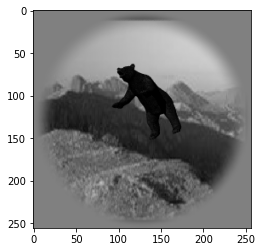

ship0
Boats


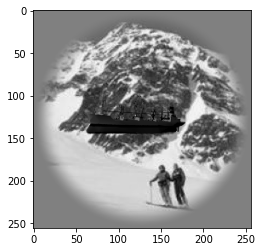

car_astra
Cars


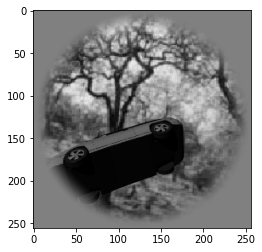

chair2
Chairs


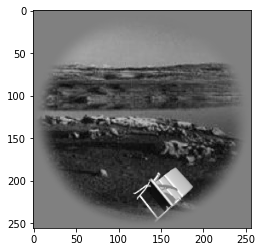

face3
Faces


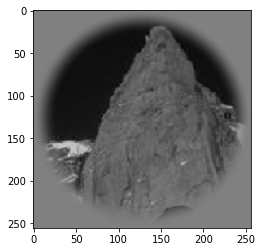

raspberry
Fruits


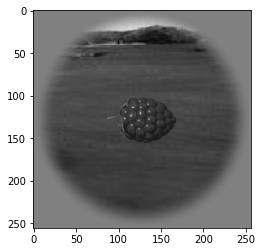

airplane5
Planes


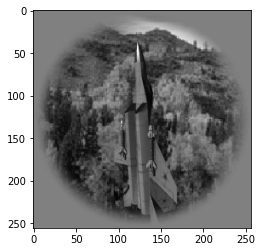

table6
Tables


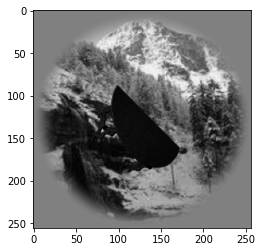

In [53]:
for i in range(1, 5760, 800):
    plt.figure()
    plt.imshow(images[i].transpose(1,2,0)/255)
    print(Majaj2015t.object_name.values[i])
    print(Majaj2015t.category_name.values[i])
    plt.show()

In [55]:
data = Majaj2015t.sel(region='IT').values.transpose(2,1,0)
data.shape

(36, 5760, 101)

In [56]:
f = h5.File('MajajHong2015', 'w')

In [60]:
# save stimuli
f.create_dataset('stimuli', data=images, maxshape=images.shape)

# chabo
data = Majaj2015t.sel(region='IT', animal='Chabo').values.transpose(2,1,0)
f.create_dataset('chabo/left', data=data, maxshape=data.shape)

# and Tito
data = Majaj2015t.sel(region='IT', animal='Tito').values.transpose(2,1,0)
f.create_dataset('tito/left', data=data, maxshape=data.shape)

<HDF5 dataset "left": shape (36, 5760, 63), type "<f4">

In [61]:
f.close()

In [62]:
f = h5.File('MajajHong2015', 'r')

In [67]:
f['chabo']['left'].shape, f['tito']['left'].shape, f['stimuli'].shape

((36, 5760, 38), (36, 5760, 63), (5760, 3, 256, 256))

In [68]:
f.close()

In [ ]:
# for merging Majaj and Sachi data, use function below.

In [15]:
#
f = h5.File('../neural_data/MajajHong2015.h5', 'r')

In [43]:
f['chabo']['left'].shape, f['tito']['left'].shape, f['stimuli'].shape

((36, 5760, 38), (36, 5760, 63), (5760, 3, 256, 256))

In [45]:
f2 = h5.File('../neural_data/SachiMajajHong2015.h5', 'w')

In [46]:
# save stimuli
f2.create_dataset('stimuli', data=f['stimuli'].value)

# chabo
f2.create_dataset('chabo/left', data=f['chabo/left'])

# Tito
f2.create_dataset('tito/left', data=f['tito/left'])

# Solo
f2.create_dataset('solo/left', data=Sachi2020t.sel(region='IT', animal='Solo').values)

# add HVM variation and other info
variations = [stimulus_set[stimulus_set['image_id']==im_id]['variation'].item() for im_id in Sachi2020t['image_id'].values]
f2.create_dataset('var', data=variations)
f2.create_dataset('object_name', data=Sachi2020t['object_name'].values.astype('S10'))
f2.create_dataset('category_name', data=Sachi2020t['category_name'].values.astype('S10'))

/home/joeldapello/anaconda3/envs/mftma/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


<HDF5 dataset "category_name": shape (5760,), type "|S10">

In [47]:
f2.close()

In [18]:
## verify match alignment of Sachi and prior HVM dataset

bear
Animals


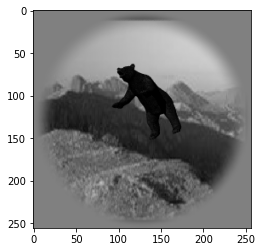

ship0
Boats


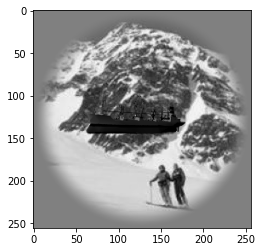

car_astra
Cars


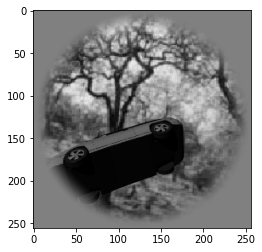

chair2
Chairs


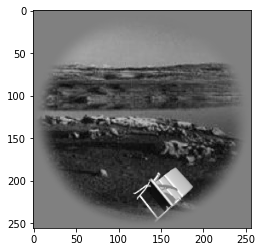

face3
Faces


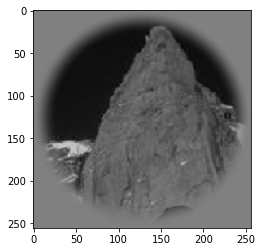

raspberry
Fruits


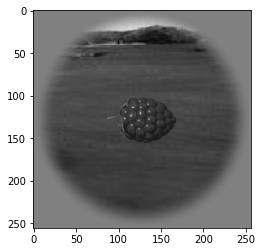

airplane5
Planes


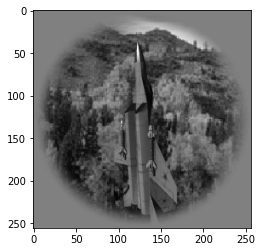

table6
Tables


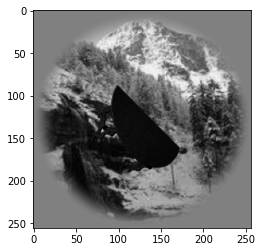

In [17]:
for i in range(1, 5760, 800):
    plt.figure()
    plt.imshow(f['stimuli'][i].transpose(1,2,0)/255)
    print(Sachi2020t.object_name.values[i])
    print(Sachi2020t.category_name.values[i])
    plt.show()

(36, 5760, 38) (36, 5760, 63) (36, 5760, 88)
3
b'bear'
b'Animals'


/home/joeldapello/anaconda3/envs/mftma/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


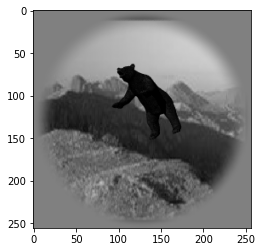

0
b'gorilla'
b'Animals'


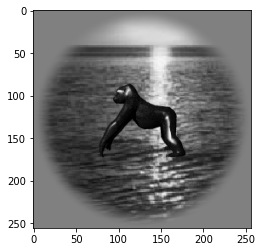

3
b'ship0'
b'Boats'


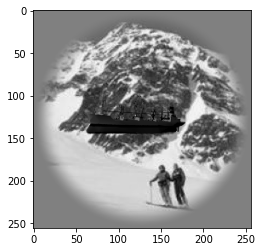

0
b'ship5'
b'Boats'


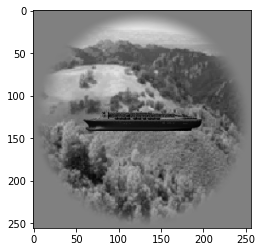

6
b'car_astra'
b'Cars'


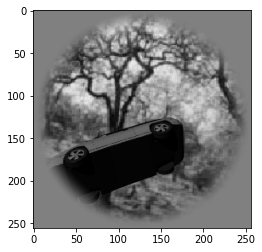

3
b'car_clio'
b'Cars'


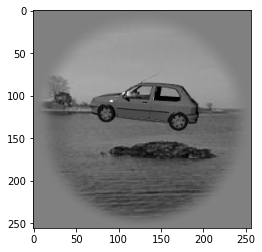

6
b'chair2'
b'Chairs'


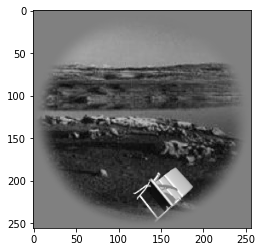

3
b'chair7'
b'Chairs'


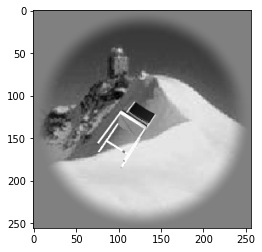

6
b'face3'
b'Faces'


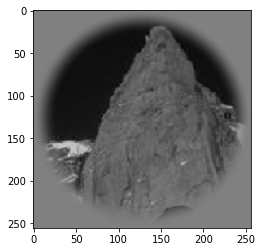

6
b'apple'
b'Fruits'


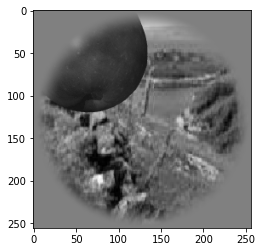

0
b'raspberry'
b'Fruits'


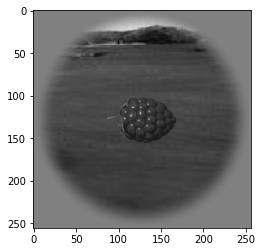

3
b'airplane0'
b'Planes'


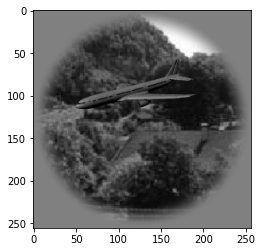

6
b'airplane5'
b'Planes'


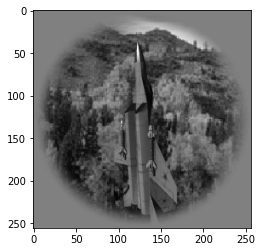

6
b'table1'
b'Tables'


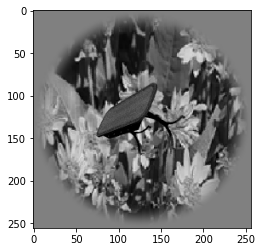

6
b'table6'
b'Tables'


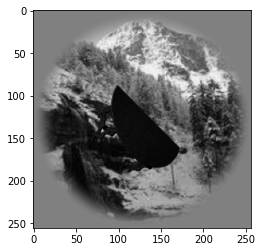

In [49]:
f2 = h5.File('../neural_data/SachiMajajHong2015.h5', 'r')
print(f2['chabo/left'].value.shape, f2['tito/left'].value.shape, f2['solo/left'].value.shape)
for i in range(1, 5760, 400):
    plt.figure()
    plt.imshow(f2['stimuli'][i].transpose(1,2,0)/255)
    print(f2['var'][i])
    print(f2['object_name'][i])
    print(f2['category_name'][i])
    plt.show()
    
f2.close()

In [22]:
def merge_data(Majaj, Sachi, region='IT', variation=None, start=0, animal=None):
    # make sure images are aligned
    assert all(Majaj.image_id.values == Sachi.image_id.values)
    
    # make sure time bins are aligned
    assert all(Majaj.time_bin_start.values == Sachi.time_bin_start.values)
    assert all(Majaj.time_bin_end.values == Sachi.time_bin_end.values)
    
    if start is not None:
        Majaj = Majaj.sel(time_bin_start=start)
        Sachi = Sachi.sel(time_bin_start=start)
    
    if region is not None:
        Majaj = Majaj.sel(region=region)
        Sachi = Sachi.sel(region=region)
    
    if variation is not None:
        Majaj = Majaj.sel(variation=variation)
        Sachi = Sachi.sel(variation=variation)
        
    if animal is not None:
        if isinstance(animal, list):
            animals = animal
        else:
            animals = [animal]
        Majaj = Majaj.where(Majaj.animal.isin(animals), drop=True)
        Sachi = Sachi.where(Sachi.animal.isin(animals), drop=True)
    
    object_names = Majaj['object_name'].values
        
    X = np.concatenate([
        Majaj.squeeze('time_bin_end').values,
        Sachi.squeeze('time_bin').values
    ])
    
    X = X.T
    # X is now [Stimuli x Neurons] at a given time point
    return X, object_names

def process_data(X, P, M, N, NORMALIZE):
    if X.shape[-1] > N:
        print(f'Original X shape: {X.shape}')
        X = random_projection(X, N)
#         X = RP.project(X)
        print(f'New X shape: {X.shape}')
    
    if NORMALIZE:
        X = normalize(X) 

    # convert to (P, M, N), assuming we have 50 classes, with examples in order
    X = X.reshape(P, M, -1) 

    # convert to [(N,M1)...(N,Mp)]
    X = [manifold.T for manifold in X]
    return X

def random_projection(X, N_cur, seed=0):
    # fixing the seed will use the same RP for feature projections of the same size.
    np.random.seed(seed)
    N = X.shape[1]  # original feature #
    W = np.random.randn(N, N_cur) # randn([pix # x neuron #])
    W = W/np.tile(np.sqrt((W**2).sum(axis=0)), [N,1]) # normalize columns of W
    return np.dot(X,W) # project stimuli onto W

def normalize(X):
    # expects X shaped # stimuli x num features and returns unit wise normalized features.
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X

In [23]:
X, object_names = merge_data(Majaj2015t, Sachi2020t, region='V4', variation=3, start=120)
X.shape

/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


(2560, 126)

Note, 126 V4 neurons

In [24]:
X, object_names = merge_data(Majaj2015t, Sachi2020t, region='IT', variation=3, start=120)
X.shape

(2560, 189)

and 189 IT neurons

## from here, you can start working with the data. 
below I save a bunch of formatted datasets to be processed on openmind, and after that I process some inline.

## format the data and save it for use a server

In [25]:
from helpers import save

In [26]:
# specify which animal(s) to process
animals = [
#     'Chabo', 
#     'Tito', 
#     'Solo', 
#     ['Chabo', 'Tito'], 
#     ['Chabo', 'Solo'], 
    ['Chabo', 'Tito', 'Solo']
]

# and region
regions = ['V4', 'IT']

# and HVM variation
variations = [3,6]
variations = [0]

# get all the time bin starts
starts = np.unique(Majaj2015t.time_bin_start.values)

for animal in animals:
    for region in regions:
        for variation in variations:
            for start in starts:
                print(f'start: {start}, var: {variation}, region: {region}')
                X, object_names = merge_data(
                    Majaj2015t, Sachi2020t, 
                    region=region, variation=variation, start=start, animal=animal
                )

                P = len(set(object_names))
                M = int(X.shape[0]/P)

                # we'll just use the existing number of neurons
                N = X.shape[-1]

                X = process_data(X, P, M, N, NORMALIZE=False)                
                X = np.array(X)
                
                # if we select multiple animals, concatenate; ie [Chabo, Tito] => "ChaboTito"
                if isinstance(animal, list):
                    animal_ = ''.join(animal)
                else:
                    animal_ = animal
                
                # finally, save the data to files
                path = f'formatted_data/animal_{animal_}-var_{variation}-region_{region}-time_{start}-norm_none-window_20ms'
                save(path, X)

start: -70, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-70-norm_none-window_20ms
start: -60, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-60-norm_none-window_20ms
start: -50, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-50-norm_none-window_20ms
start: -40, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-40-norm_none-window_20ms
start: -30, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-30-norm_none-window_20ms
start: -20, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-20-norm_none-window_20ms
start: -10, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_-10-norm_none-window_20ms
start: 0, var: 0, region: V4
Saved  formatted_data/animal_ChaboTitoSolo-var_0-region_V4-time_0-norm_none-window_20ms
start: 10, var: 0, region: V4
Saved 

## Atlernately, we can analyze the data here

In [32]:
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.alldata_dimension_analysis import alldata_dimension_analysis

In [29]:
kappa = 0
n_t = 200

regions = ['V4', 'IT']
variations = [3,6,None]
starts = np.unique(Majaj2015t.time_bin_start.values)

dfs = []
for region in regions:
    for variation in variations:
        for start in starts:
            X, object_names = merge_data(
                Majaj2015t, Sachi2020t, region=region, variation=variation, start=start
            )
            
            P = len(set(object_names))
            M = int(X.shape[0]/P)
            
            # we will always project to 175 neurons, the number of neurons in V4
            N = 175
            
            ## note: normalization is happening for each individual stimuli set.
            X = process_data(X, P, M, N, NORMALIZE=True)
            
            capacity_all, radius_all, dimension_all, center_correlation, K = [np.array([0]), np.array([0]), np.array([0]), 0, 0]
#             capacity_all, radius_all, dimension_all, center_correlation, K = manifold_analysis_corr(X, kappa, n_t)
            D_participation_ratio, D_explained_variance, D_feature = alldata_dimension_analysis(X, perc=90)

            df = pd.DataFrame(
                columns = ['cap', 'dim', 'rad'],
                data = np.array([
                        capacity_all,
                        dimension_all,
                        radius_all
                ]).T
            )
            df['mean_cap'] = 1/np.mean(1/capacity_all)
            df['center_corr'] = center_correlation
            df['K'] = K
            df['EVD90'] = D_explained_variance
            df['PR'] = D_participation_ratio
            df['measured_features'] = D_feature
            df['region'] = region
            df['variation'] = variation
            df['time_bin_start'] = start
            dfs.append(df)

/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,
/home/jo

KeyboardInterrupt: 

In [212]:
df = pd.concat(dfs)

df.to_csv('local_mft_results/Majaj2015_and_Sachi2020-20ms.csv')

In [224]:
# use this to load previously computed df (saved above)
df = pd.read_csv('local_mft_results/Majaj2015_and_Sachi2020-20ms.csv')

## below I just compute dimensionality for Tito

In [34]:
kappa = 0
n_t = 200

animals = ['Tito']
regions = ['V4', 'IT']
variations = [3,6]
starts = np.unique(Majaj2015t.time_bin_start.values)

dfs = []

for animal in animals:
    for region in regions: 
        for variation in variations:
            for start in starts:
                print(f'{animal} {region} {variation} {start}')
                X, object_names = merge_data(
                    Majaj2015t, Sachi2020t, region=region, variation=variation, start=start, animal=animal
                )

                P = len(set(object_names))
                M = int(X.shape[0]/P)

                # we will always project to 175 neurons, the number of neurons in V4
                N = 175

                ## note: normalization is happening for each individual stimuli set.
                X = process_data(X, P, M, N, NORMALIZE=False)

                capacity_all, radius_all, dimension_all, center_correlation, K = [np.array([0]), np.array([0]), np.array([0]), 0, 0]
    #             capacity_all, radius_all, dimension_all, center_correlation, K = manifold_analysis_corr(X, kappa, n_t)
                D_participation_ratio, D_explained_variance, D_feature = alldata_dimension_analysis(X, perc=90)

                df = pd.DataFrame(
                    columns = ['cap', 'dim', 'rad'],
                    data = np.array([
                            capacity_all,
                            dimension_all,
                            radius_all
                    ]).T
                )
                df['mean_cap'] = 1/np.mean(1/capacity_all)
                df['center_corr'] = center_correlation
                df['K'] = K
                df['EVD90'] = D_explained_variance
                df['PR'] = D_participation_ratio
                df['measured_features'] = D_feature
                df['animal'] = animal
                df['region'] = region
                df['variation'] = variation
                df['time_bin_start'] = start
                dfs.append(df)

Tito V4 3 -70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 -10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 0


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 80


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 90


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 100


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 110


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 120


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 130


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 140


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 150


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 160


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 170


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 180


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 190


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 200


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 210


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 220


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 230


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 240


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 250


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 260


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 270


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 3 280


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 -10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 0


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 80


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 90


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 100


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 110


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 120


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 130


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 140


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 150


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 160


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 170


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 180


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 190


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 200


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 210


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 220


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 230


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 240


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 250


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 260


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 270


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito V4 6 280


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 -10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 0


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 80


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 90


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 100


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 110


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 120


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 130


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 140


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 150


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 160


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 170


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 180


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 190


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 200


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 210


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 220


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 230


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 240


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 250


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 260


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 270


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 3 280


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 -10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 0


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 10


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 20


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 30


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 40


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 50


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 60


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 70


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 80


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 90


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 100


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 110


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 120


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 130


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 140


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 150


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 160


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 170


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 180


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 190


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 200


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 210


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 220


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 230


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 240


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 250


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 260


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 270


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/xarray/core/dataset.py:2218: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


Tito IT 6 280


/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [35]:
df = pd.concat(dfs)

## and visualize here for convenience as well

In [36]:
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import image
from mpl_toolkits.axes_grid1 import ImageGrid

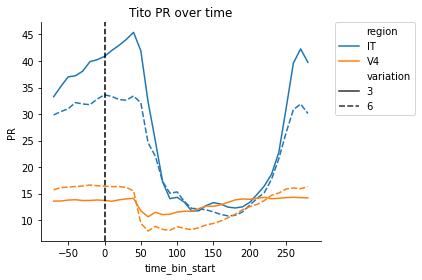

In [38]:
# filter data by just Tito
animal = 'Tito'
measure = 'PR'

data = df[df['animal']==animal]


ax = sns.lineplot(x='time_bin_start', y=measure, hue='region', hue_order=['IT', 'V4'], style='variation', data=data)
ax.axvline(x=0, linestyle='--', color='black')
sns.despine()
ax.set_title(f'{animal} {measure} over time')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.tight_layout()

In [20]:
import numpy as np
import brainscore

In [ ]:
neural_data = brainscore.get_assembly(name="dicarlo.MajajHong2015.public")

In [6]:
compact_data = neural_data.multi_groupby(['category_name', 'object_name', 'image_id']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)
compact_data

/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/joeldapello/anaconda3/envs/mftma/lib/python3.6/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: list(self.group_coord_names)})


<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (presentation: 3200, neuroid: 168)>
array([[ 0.1962  ,  0.10559 ,  0.430899, ...,  0.254563, -0.103698,  0.400337],
       [-0.188017, -0.599624, -0.02469 , ...,  0.108069,  0.243771,  0.13458 ],
       [ 0.576654,  0.242336, -0.229085, ...,  0.312417, -0.155798,  0.012417],
       ...,
       [ 0.608051,  0.17681 , -0.110604, ...,  0.123359,  0.14819 ,  0.076451],
       [ 0.014948, -0.243371, -0.238544, ...,  0.593095,  0.112013, -0.267446],
       [-0.107264, -0.029414, -0.074609, ..., -0.297466,  0.482114,  0.243566]],
      dtype=float32)
Coordinates:
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) object 'Chabo_L_M_5_9' ... 'Chabo_L_A_4_4'
  - arr            (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'A' 'A' 'A' 'A' 'A'
  - col            (neuroid) int64 9 9 8 9 8 8 7 7 5 6 4 ... 5 6 4 5 3 4 5 4 5 4
  - hemisphere     (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion      (n

In [49]:
stimulus_set = neural_data.attrs['stimulus_set']
image_ids = [im for im in stimulus_set['image_id']]
images_dict = {im:image.imread(stimulus_set.get_image(im)) for im in image_ids}

image_ids = compact_data.image_id.values
images = np.array([images_dict[im_id] for im_id in image_ids])

In [56]:
np.save('HvM_public_IT', compact_data.values)
np.save('HvM_public_cat', compact_data.category_name.values)
np.save('HvM_public_obj', compact_data.object_name.values)
np.save('HvM_public_imgid', compact_data.image_id.values)
np.save('HvM_public_imgs', images)